In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torchvision import transforms, datasets
import torchvision.transforms.functional as fn
import torchvision.transforms
from PIL import Image

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [44]:
WANDB_LOGGING = False
config = {
    "dataloader": {
        "batch_size": 32
    }
}

## Loading and Transforming the Dataset

In this project we are working with imamges of vegetables and classifying them into 15 distinct classes.

The images were downloaded from: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset. There are 21,000 images in total. The images are already split into 3 sets - training(70%), validation(15%) and testing(15%). However, the percentages (provided on the website) are only rough estimations - in actuality, there are 15,000 training images, and 3000 of each - validation and testing images - which makes it a 71,4285...%, 14,2857...%, 14,2857...% split...

We begin by loading the images from the downloaded repository using the `ImageFolder` object from the `torchvision.datasets` module, immediately giving them transformations defined in the two following blocks of code. First of all, we need to make sure that the images are the same size, so we resize all of them to 224x224 pixels. In addition to that, we augment the training images by doing random rotations and random resized crops (within a range of 80-100% of the original image). 

In [45]:
transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
        #                     [0.229, 0.224, 0.225])
])

In [46]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.5, 0.5, 0.5], 
                                                            #[0.5, 0.5, 0.5])])
                                    ])

In [47]:
train_dataset = ImageFolder('data/Vegetable Images/train', transform=train_transform)
val_dataset = ImageFolder('data/Vegetable Images/validation', transform=transform)
test_dataset = ImageFolder('data/Vegetable Images/test', transform=transform)


train_dataloader = DataLoader(train_dataset, batch_size=config["dataloader"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["dataloader"]["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=config["dataloader"]["batch_size"], shuffle=False)

print(f"Number of Training Images: {len(train_dataset)} - Validation Images: {len(val_dataset)} - Test Images: {len(test_dataset)}")
print(f"Number of target classes: {len(train_dataset.classes)}")
print(f"Names of the classes: {(train_dataset.classes)}")



Number of Training Images: 15000 - Validation Images: 3000 - Test Images: 3000
Number of target classes: 15
Names of the classes: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [57]:
len(train_dataloader)

469

An example of a training image after augmentation

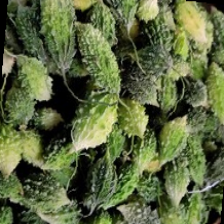

In [48]:
images, labels = next(iter(train_dataloader))
fn.to_pil_image(images[0])

## Defining the Neural Network Architecture

In [49]:
class VegetableClassifier(nn.Module):
    def __init__(self, network: nn.Sequential, network_out: int, num_classes: int=15) -> None:
        super(VegetableClassifier, self).__init__()
        self.classifier_out = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = network
        self.avg_maxpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear_classifier = nn.Linear(in_features=network_out, out_features=self.classifier_out)
        
    def forward(self, input):
        input = self.network(input)
        input = self.avg_maxpool(input)
        input = torch.flatten(input, 1)
        return self.linear_classifier(input)
                

In [50]:
network_1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
)

In [51]:
network_2 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(64),
)

In [52]:
network_2 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

    nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(128),

    nn.Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
    nn.BatchNorm2d(512),
)

In [53]:
import wandb
if WANDB_LOGGING:
    sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [5, 10, 15]},
        'lr': {'max': 0.1, 'min': 0.0001}
     }
    }
    wandb.init()

In [54]:
from tqdm.auto import tqdm  # We use tqdm to display a simple progress bar, allowing us to observe the learning progression.

def get_accuracy(pred, y):
    pred = pred.argmax(dim=1) # Get the largest value for each image - the predicted class
    correct = torch.eq(y, pred).sum().item()
    acc = (correct / len(pred))
    return acc

def fit(model: nn.Module,
        device: torch.device,
        num_epochs: int,
          loss_fn,
            optimizer: torch.optim.Optimizer,
              train_dataloader: DataLoader,
                test_dataloader: DataLoader,
                  print_rate: int = 100):
    # Iterate through epochs with tqdm
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch: {epoch}\n")
        # Setup train loss that will accumulate over each batch
        train_loss = 0
        # Iterate through batches in each epoch
        for batch, (X, y) in enumerate(train_dataloader):
            # Pass the tensors to device
            X, y = X.to(device), y.to(device)
            # Set mode of model to train
            model.train()
            # Get the loss
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss
            # Getting the loss gradient and making an optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch % print_rate == 0) or (batch == len(train_dataloader) - 1): 
                print(f"Looked at {batch} Batches\t---\t{batch * len(X)}/{len(train_dataloader.dataset)} Samples")
        # Devide the train_loss by the number of batches to get the average train_loss
        avg_train_loss = train_loss / len(train_dataloader)

        # Testing
        # Setup the Test Loss and Accuracy to accumulate over the batches in the test data set
        test_loss = 0
        test_acc = 0
        # Set model to evaluation mode and use torch.inference_mode to remove unnecessary training operations 
        model.eval()
        with torch.inference_mode():
            for X_test, y_test in test_dataloader:
                X_test, y_test = X_test.to(device), y_test.to(device)

                test_pred = model(X_test)
                test_loss += loss_fn(test_pred, y_test)
                test_acc += get_accuracy(pred=test_pred, y=y_test)

        # Get the average Test Loss and Accuracy
        avg_test_loss = test_loss / len(test_dataloader)
        avg_test_acc = test_acc / len(test_dataloader)

        print(f"Train loss: {avg_train_loss} | Test Loss: {avg_test_loss} | Test Accuracy: {avg_test_acc}")
        if WANDB_LOGGING:
            wandb.log({"Train Loss": avg_train_loss,"Test Loss": avg_test_loss, "Test Accuracy": avg_test_acc})

In [55]:
model = VegetableClassifier(network=network_2, network_out=512)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
loss_fn = nn.CrossEntropyLoss()

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)
fit(model=model, num_epochs=5, device=device, loss_fn=loss_fn, optimizer=optimizer, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0

Looked at 0 Batches	---	0/15000 Samples
Looked at 100 Batches	---	3200/15000 Samples
Looked at 200 Batches	---	6400/15000 Samples
Looked at 300 Batches	---	9600/15000 Samples
Looked at 400 Batches	---	12800/15000 Samples


  0%|          | 0/5 [01:19<?, ?it/s]


KeyboardInterrupt: 